# Data Description

The aim of this competition is to predict a patient’s severity of decline in lung function based on a CT scan of their lungs. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled.

In the dataset, you are provided with a baseline chest CT scan and associated clinical information for a set of patients. A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured.

* In the training set, you are provided with an anonymized, baseline CT scan and the entire history of FVC measurements.
* In the test set, you are provided with a baseline CT scan and only the initial FVC measurement. You are asked to predict the final three FVC measurements for each patient, as well as a confidence value in your prediction. 

There are around 200 cases in the public & private test sets, combined. This is split roughly 15-85 between public-private.

Since this is real medical data, you will notice the relative timing of FVC measurements varies widely. The timing of the initial measurement relative to the CT scan and the duration to the forecasted time points may be different for each patient. This is considered part of the challenge of the competition. To avoid potential leakage in the timing of follow up visits, you are asked to predict every patient's FVC measurement for every possible week. Those weeks which are not in the final three visits are ignored in scoring.
## Files

This is a synchronous rerun code competition. The provided test set is a small representative set of files (copied from the training set) to demonstrate the format of the private test set. When you submit your notebook, Kaggle will rerun your code on the test set, which contains unseen images.

train.csv - the training set, contains full history of clinical information
test.csv - the test set, contains only the baseline measurement
train/ - contains the training patients' baseline CT scan in DICOM format
test/ - contains the test patients' baseline CT scan in DICOM format
sample_submission.csv - demonstrates the submission format *italicized text*

## Columns
train.csv and test.csv

* Patient- a unique Id for each patient (also the name of the patient's DICOM folder)
* Weeks- the relative number of weeks pre/post the baseline CT (may be negative)
* FVC - the recorded lung capacity in ml
* Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
  * Age
  * Sex
  * SmokingStatus 

sample submission.csv

* Patient_Week - a unique Id formed by concatenating the Patient and Weeks columns (i.e. ABC_22 is a prediction for patient ABC at week 22)
* FVC - the predicted FVC in ml
* Confidence - a confidence value of your prediction (also has units of ml) 


# **Visualizations**
## On data containing CT scan of patients

In [45]:
pip install pydicom

In [46]:
import matplotlib.pyplot as plt # plotting
from matplotlib.pyplot import figure
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # Decorate an iterable object, returning an iterator which acts exactly like the original iterable, 
                      # but prints a dynamically updating progressbar every time a value is requested
import seaborn as sns #Seaborn is a library for making statistical graphics in Python
from pandas.plotting import table 
import time # provides various time-related functions
from datetime import timedelta #timedelta:- A duration expressing the difference between two date, time, or datetime.
from google.colab import drive # Downloading Datasets into Google Drive via Google Colab
import os.path

import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_file

import matplotlib
import matplotlib.animation as animation
from matplotlib.widgets import Slider

import scipy.ndimage
from skimage import measure
import plotly.graph_objects as go
from plotly.figure_factory import create_trisurf
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from glob import glob
from IPython.display import HTML

In [47]:
#Functions to save objects for future usage and repossess
#https://stackoverflow.com/questions/1253528/is-there-an-easy-way-to-pickle-a-python-function-or-otherwise-serialize-its-cod
import pickle
def transmit(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def receive(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [48]:
drive.mount('/content/drive') # for mounting Google Drive files 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
## List out the available directories in the first Drive path
print('Available dataset partitions: ', os.listdir('drive/My Drive/Colab Notebooks'))
print('Available files in dataset in drive: ', os.listdir('drive/My Drive/Colab Notebooks/train1'))

Available dataset partitions:  ['.csv', 'sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train1', 'Untitled0.ipynb', 'Untitled1.ipynb', 'Untitled.ipynb', 'Pulmonary_Fibrosis_EDA_FVC_dicom.ipynb', 'Untitled (1)', 'Untitled', 'OSIC Pulmonary project_sol.ipynb', 'pixel_array_dcm_1.txt', 'OSIC_Pulmonary_project_CNN_model_vgg19_5_25_2021_running.ipynb', 'OSIC_Pulmonary_project_CNN_model_vgg19_5_28_2021_running_vgg19_16_reset50_II.ipynb', 'OSIC_Pulmonary_project_CNN_model_vgg19_6_4_2021_running_vgg19_16_reset50_IIV.ipynb', 'OSIC_Pulmonary_project_CNN_model_vgg19_7_4_2021_running_vgg19_16_reset50_IIV_test_res50_1_4.ipynb', 'OSIC_Pulmonary_project_CNN_model_efficientnetB4_XIV_5.ipynb', 'OSIC_Pulmonary_project_CNN_model_efficientnetB4_8image_concat.ipynb', 'submission_6image.csv', 'submission_2effnet.csv', 'Pulmonary_Fibrosis_EDA_FVC.ipynb', 'Pulmonary_Fibrosis_EDA_Dicom_FVC1.ipynb']
Available files in dataset in drive:  ['ID00197637202246865691526', 'ID00207637202252526380974', 'ID00

In [6]:
#Below code will allow us to access two drive at a time 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!sudo mkdir /content/drive1
!google-drive-ocamlfuse /content/drive1

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [7]:
## List out the available directories in the second Drive1 path
print('Available dataset partitions: ', os.listdir('drive1/Colab Notebooks'))

Available dataset partitions:  ['Untitled0.ipynb', 'train2', 'pixel_array_dcm_1.txt', 'OSIC_Pulmonary_project_CNN_model_vgg19_5_26_2021_running_vgg19_16_reset50.ipynb', 'OSIC_Pulmonary_project_CNN_model_vgg19_7_4_2021_running_vgg19_16_reset50_IIV_test_res50.ipynb', 'OSIC_Pulmonary_project_CNN_model_efficientnet_II.ipynb', 'OSIC_Pulmonary_project_CNN_model_efficientnet_III.ipynb', 'OSIC_Pulmonary_project_CNN_model_efficientnet_VII.ipynb', 'OSIC_Pulmonary_project_CNN_model_efficientnetB4_XIV.ipynb', 'OSIC_Pulmonary_project_CNN_model_efficientnetB4_2image_concat.ipynb', 'submission_6image.csv', 'submission_2effnet.csv', 'model_2_image.h5']


In [8]:
! dir

adc.json  drive  drive1  sample_data


In [9]:
# Number of folder having patient ID as folder name
print('Available files in dataset in drive1: ', os.listdir('drive1/Colab Notebooks/train2'))

Available files in dataset in drive1:  ['ID00009637202177434476278', 'ID00019637202178323708467', 'ID00014637202177757139317', 'ID00007637202177411956430', 'ID00023637202179104603099', 'ID00010637202177584971671', 'ID00011637202177653955184', 'ID00015637202177877247924', 'ID00020637202178344345685', 'ID00012637202177665765362', 'ID00032637202181710233084', 'ID00026637202179561894768', 'ID00047637202184938901501', 'ID00042637202184406822975', 'ID00048637202185016727717', 'ID00025637202179541264076', 'ID00027637202179689871102', 'ID00035637202182204917484', 'ID00038637202182690843176', 'ID00030637202181211009029', 'ID00060637202187965290703', 'ID00067637202189903532242', 'ID00075637202198610425520', 'ID00062637202188654068490', 'ID00068637202190879923934', 'ID00072637202198161894406', 'ID00052637202186188008618', 'ID00061637202188184085559', 'ID00073637202198167792918', 'ID00051637202185848464638', 'ID00090637202204766623410', 'ID00078637202199415319443', 'ID00082637202201836229724', 'ID

In [10]:
# Let's take the folder of patient ID ID00167637202237397919352
folder_id = 'ID00167637202237397919352'
dcm_no = os.listdir('drive1/Colab Notebooks/train2/' + folder_id)
print ('Patient ID: '+folder_id+ ' has', len(dcm_no),'image')
print(len(os.listdir('drive1/Colab Notebooks/train2/' + folder_id)))

Patient ID: ID00167637202237397919352 has 221 image
221


In [11]:
# Listing for folder containing .dcm (CT stan image) in drive 1
drive_1 = os.listdir('drive1/Colab Notebooks/train2')
print(drive_1)

['ID00126637202218610655908', 'ID00129637202219868188000', 'ID00072637202198161894406', 'ID00077637202199102000916', 'ID00076637202199015035026', 'ID00010637202177584971671', 'ID00139637202231703564336', 'ID00052637202186188008618', 'ID00015637202177877247924', 'ID00170637202238079193844', 'ID00048637202185016727717', 'ID00149637202232704462834', 'ID00086637202203494931510', 'ID00090637202204766623410', 'ID00140637202231728595149', 'ID00172637202238316925179', 'ID00030637202181211009029', 'ID00094637202205333947361', 'ID00124637202217596410344', 'ID00027637202179689871102', 'ID00167637202237397919352', 'ID00020637202178344345685', 'ID00122637202216437668965', 'ID00168637202237852027833', 'ID00173637202238329754031', 'ID00130637202220059448013', 'ID00073637202198167792918', 'ID00183637202241995351650', 'ID00127637202219096738943', 'ID00068637202190879923934', 'ID00099637202206203080121', 'ID00165637202237320314458', 'ID00123637202217151272140', 'ID00161637202235731948764', 'ID0001463720

In [12]:
# Creating a dataframe of Patient ID & No. of files for drive 1
##https://python-forum.io/Thread-build-pandas-dataframe-from-a-for-loop
import pandas as pd
df_dcm_files = pd.DataFrame({'Patient ID': [], 'No. of files': []})
for i in drive_1:
    df_dcm_files = df_dcm_files.append({'Patient ID': i, 'No. of files': len(os.listdir('drive1/Colab Notebooks/train2/' + i))}, ignore_index=True)
df_dcm_files

,Patient ID,No. of files
0,ID00126637202218610655908,17.0
1,ID00129637202219868188000,27.0
2,ID00072637202198161894406,24.0
3,ID00077637202199102000916,94.0
4,ID00076637202199015035026,64.0
...,...,...
74,ID00134637202223873059688,451.0
75,ID00035637202182204917484,574.0
76,ID00038637202182690843176,346.0
77,ID00032637202181710233084,205.0


In [13]:
#sorting by No. of files
df_dcm_files = df_dcm_files.sort_values(by ='No. of files' )

In [14]:
df_dcm_files

,Patient ID,No. of files
31,ID00165637202237320314458,12.0
0,ID00126637202218610655908,17.0
50,ID00125637202218590429387,22.0
17,ID00094637202205333947361,24.0
2,ID00072637202198161894406,24.0
...,...,...
73,ID00108637202209619669361,512.0
75,ID00035637202182204917484,574.0
37,ID00180637202240177410333,577.0
24,ID00173637202238329754031,602.0


In [15]:
# Listing for folder containing .dcm (CT stan image) in drive 2
drive_2 = os.listdir('drive/My Drive/Colab Notebooks/train1')
print(drive_2)

['ID00197637202246865691526', 'ID00207637202252526380974', 'ID00196637202246668775836', 'ID00190637202244450116191', 'ID00184637202242062969203', 'ID00186637202242472088675', 'ID00199637202248141386743', 'ID00210637202257228694086', 'ID00202637202249376026949', 'ID00192637202245493238298', 'ID00219637202258203123958', 'ID00216637202257988213445', 'ID00221637202258717315571', 'ID00213637202257692916109', 'ID00224637202259281193413', 'ID00228637202259965313869', 'ID00218637202258156844710', 'ID00214637202257820847190', 'ID00222637202259066229764', 'ID00225637202259339837603', 'ID00233637202260580149633', 'ID00242637202264759739921', 'ID00240637202264138860065', 'ID00229637202260254240583', 'ID00241637202264294508775', 'ID00248637202266698862378', 'ID00234637202261078001846', 'ID00232637202260377586117', 'ID00235637202261451839085', 'ID00249637202266730854017', 'ID00267637202270790561585', 'ID00279637202272164826258', 'ID00273637202271319294586', 'ID00251637202267455595113', 'ID0028363720

In [16]:
## Creating a dataframe of Patient ID & No. of files for drive 2
##https://python-forum.io/Thread-build-pandas-dataframe-from-a-for-loop
import pandas as pd
df_dcm_files2 = pd.DataFrame({'Patient ID': [], 'No. of files': []})
for i in drive_2:
    df_dcm_files2 = df_dcm_files2.append({'Patient ID': i, 'No. of files': len(os.listdir('drive/My Drive/Colab Notebooks/train1/' + i))}, ignore_index=True)

In [17]:
df_dcm_files2 = df_dcm_files2.sort_values(by ='No. of files' )
df_dcm_files2

,Patient ID,No. of files
97,rgb,5.0
25,ID00248637202266698862378,16.0
23,ID00229637202260254240583,17.0
17,ID00214637202257820847190,18.0
21,ID00242637202264759739921,18.0
...,...,...
90,ID00422637202311677017371,473.0
89,ID00393637202302431697467,478.0
40,ID00291637202279398396106,485.0
50,ID00317637202283194142136,521.0


In [18]:
# Joing Both dataframes 
df_dcm_files_all = pd.concat([df_dcm_files, df_dcm_files2])
df_dcm_files_all = df_dcm_files_all.sort_values(by ='No. of files' )

In [19]:
#set index from column Source, remove index name
df_dcm_files_all = df_dcm_files_all.set_index('Patient ID').rename_axis(None)

In [55]:
df_dcm_files_all

,No. of files
rgb,5.0
ID00165637202237320314458,12.0
ID00248637202266698862378,16.0
ID00229637202260254240583,17.0
ID00126637202218610655908,17.0
...,...
ID00035637202182204917484,574.0
ID00180637202240177410333,577.0
ID00173637202238329754031,602.0
ID00202637202249376026949,825.0


Patient ID: ID00165637202237320314458 has lowest number of CT Scan Files i.e. 12 on the other hand Patient ID: ID00078637202199415319443 has largest number for same i.e. 1018 Files

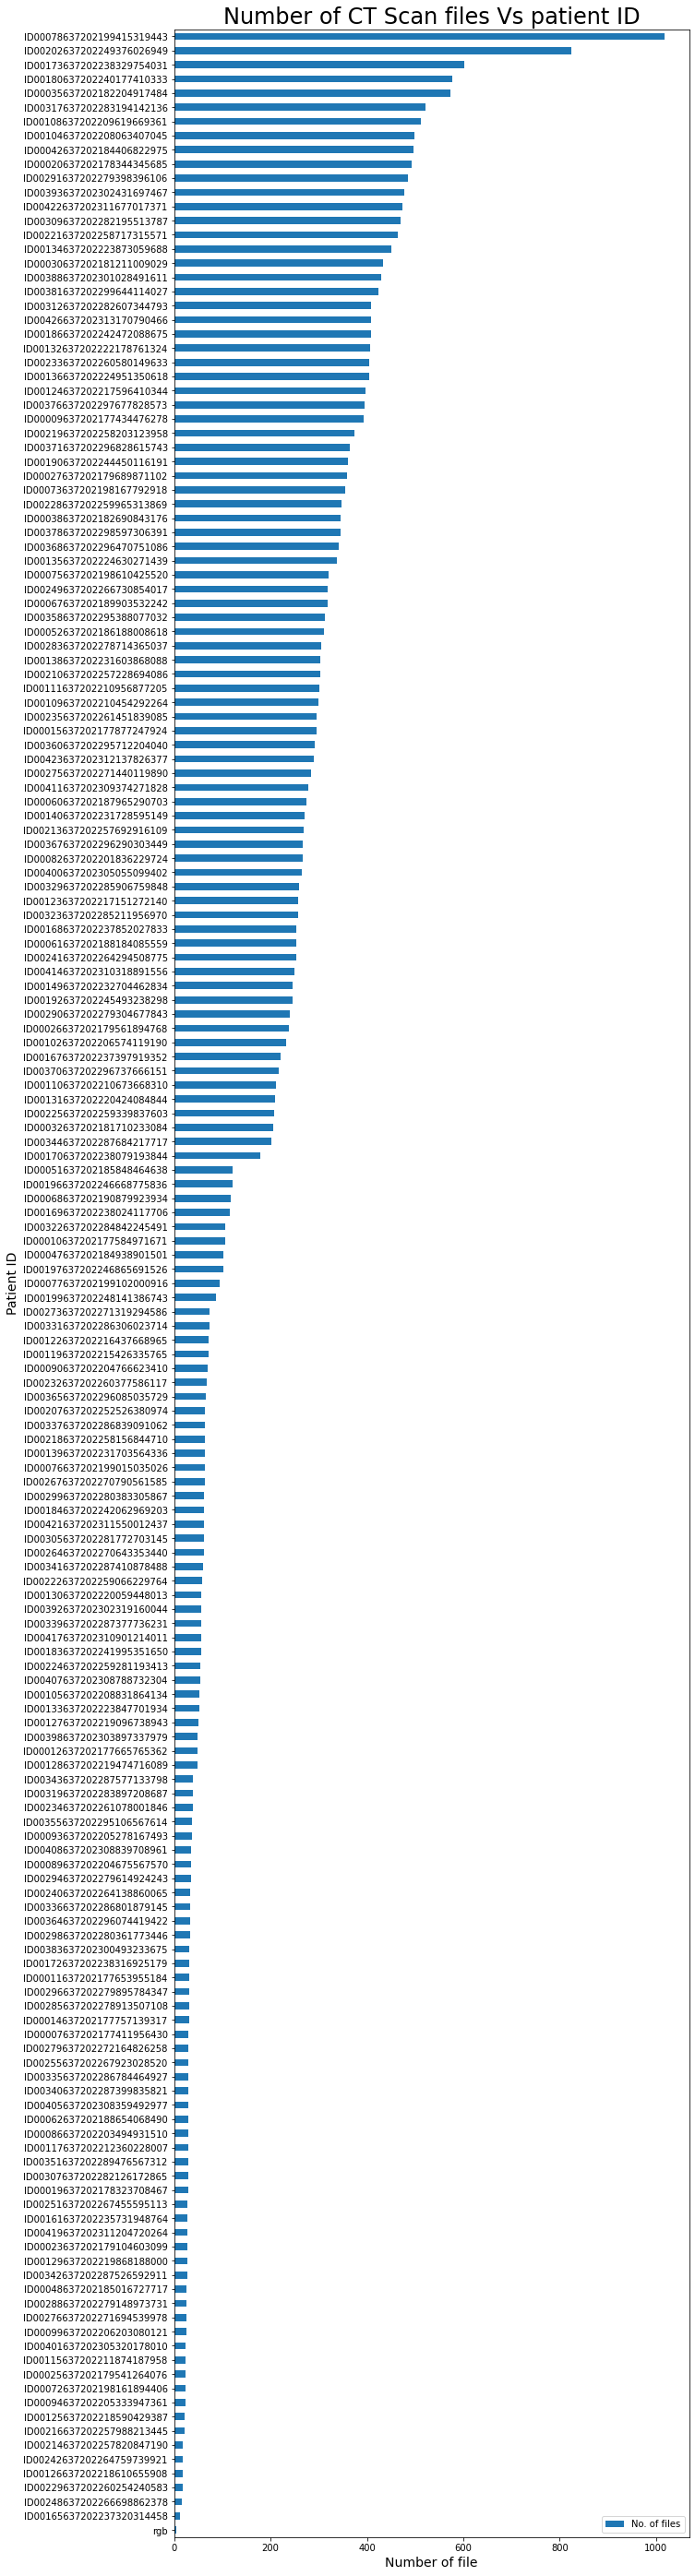

In [21]:
# Plotting Number of CT Scan files Vs patient ID
# https://stackoverflow.com/a/44381252
df_dcm_files_all.plot(kind='barh',figsize=(10,50))
plt.title('Number of CT Scan files Vs patient ID',fontsize=24)
plt.xlabel('Number of file',fontsize=14)
plt.ylabel('Patient ID',fontsize=14)
plt.show()

In [31]:
# Sorting the CT scan file in increasing order i.e. from top to bottom of chest.
dcm_ID00167637202237397919352 = os.listdir('drive1/Colab Notebooks/train2/ID00167637202237397919352')
dcm_ID00167637202237397919352.sort(reverse=False)
dcm_ID00167637202237397919352.sort( key=len,reverse=False)
print(dcm_ID00167637202237397919352)

['1.dcm', '2.dcm', '3.dcm', '4.dcm', '5.dcm', '6.dcm', '7.dcm', '8.dcm', '9.dcm', '10.dcm', '11.dcm', '12.dcm', '13.dcm', '14.dcm', '15.dcm', '16.dcm', '17.dcm', '18.dcm', '19.dcm', '20.dcm', '21.dcm', '22.dcm', '23.dcm', '24.dcm', '25.dcm', '26.dcm', '27.dcm', '28.dcm', '29.dcm', '30.dcm', '31.dcm', '32.dcm', '33.dcm', '34.dcm', '35.dcm', '36.dcm', '37.dcm', '38.dcm', '39.dcm', '40.dcm', '41.dcm', '42.dcm', '43.dcm', '44.dcm', '45.dcm', '46.dcm', '47.dcm', '48.dcm', '49.dcm', '50.dcm', '51.dcm', '52.dcm', '53.dcm', '54.dcm', '55.dcm', '56.dcm', '57.dcm', '58.dcm', '59.dcm', '60.dcm', '61.dcm', '62.dcm', '63.dcm', '64.dcm', '65.dcm', '66.dcm', '67.dcm', '68.dcm', '69.dcm', '70.dcm', '71.dcm', '72.dcm', '73.dcm', '74.dcm', '75.dcm', '76.dcm', '77.dcm', '78.dcm', '79.dcm', '80.dcm', '81.dcm', '82.dcm', '83.dcm', '84.dcm', '85.dcm', '86.dcm', '87.dcm', '88.dcm', '89.dcm', '90.dcm', '91.dcm', '92.dcm', '93.dcm', '94.dcm', '95.dcm', '96.dcm', '97.dcm', '98.dcm', '99.dcm', '100.dcm', '101.dc

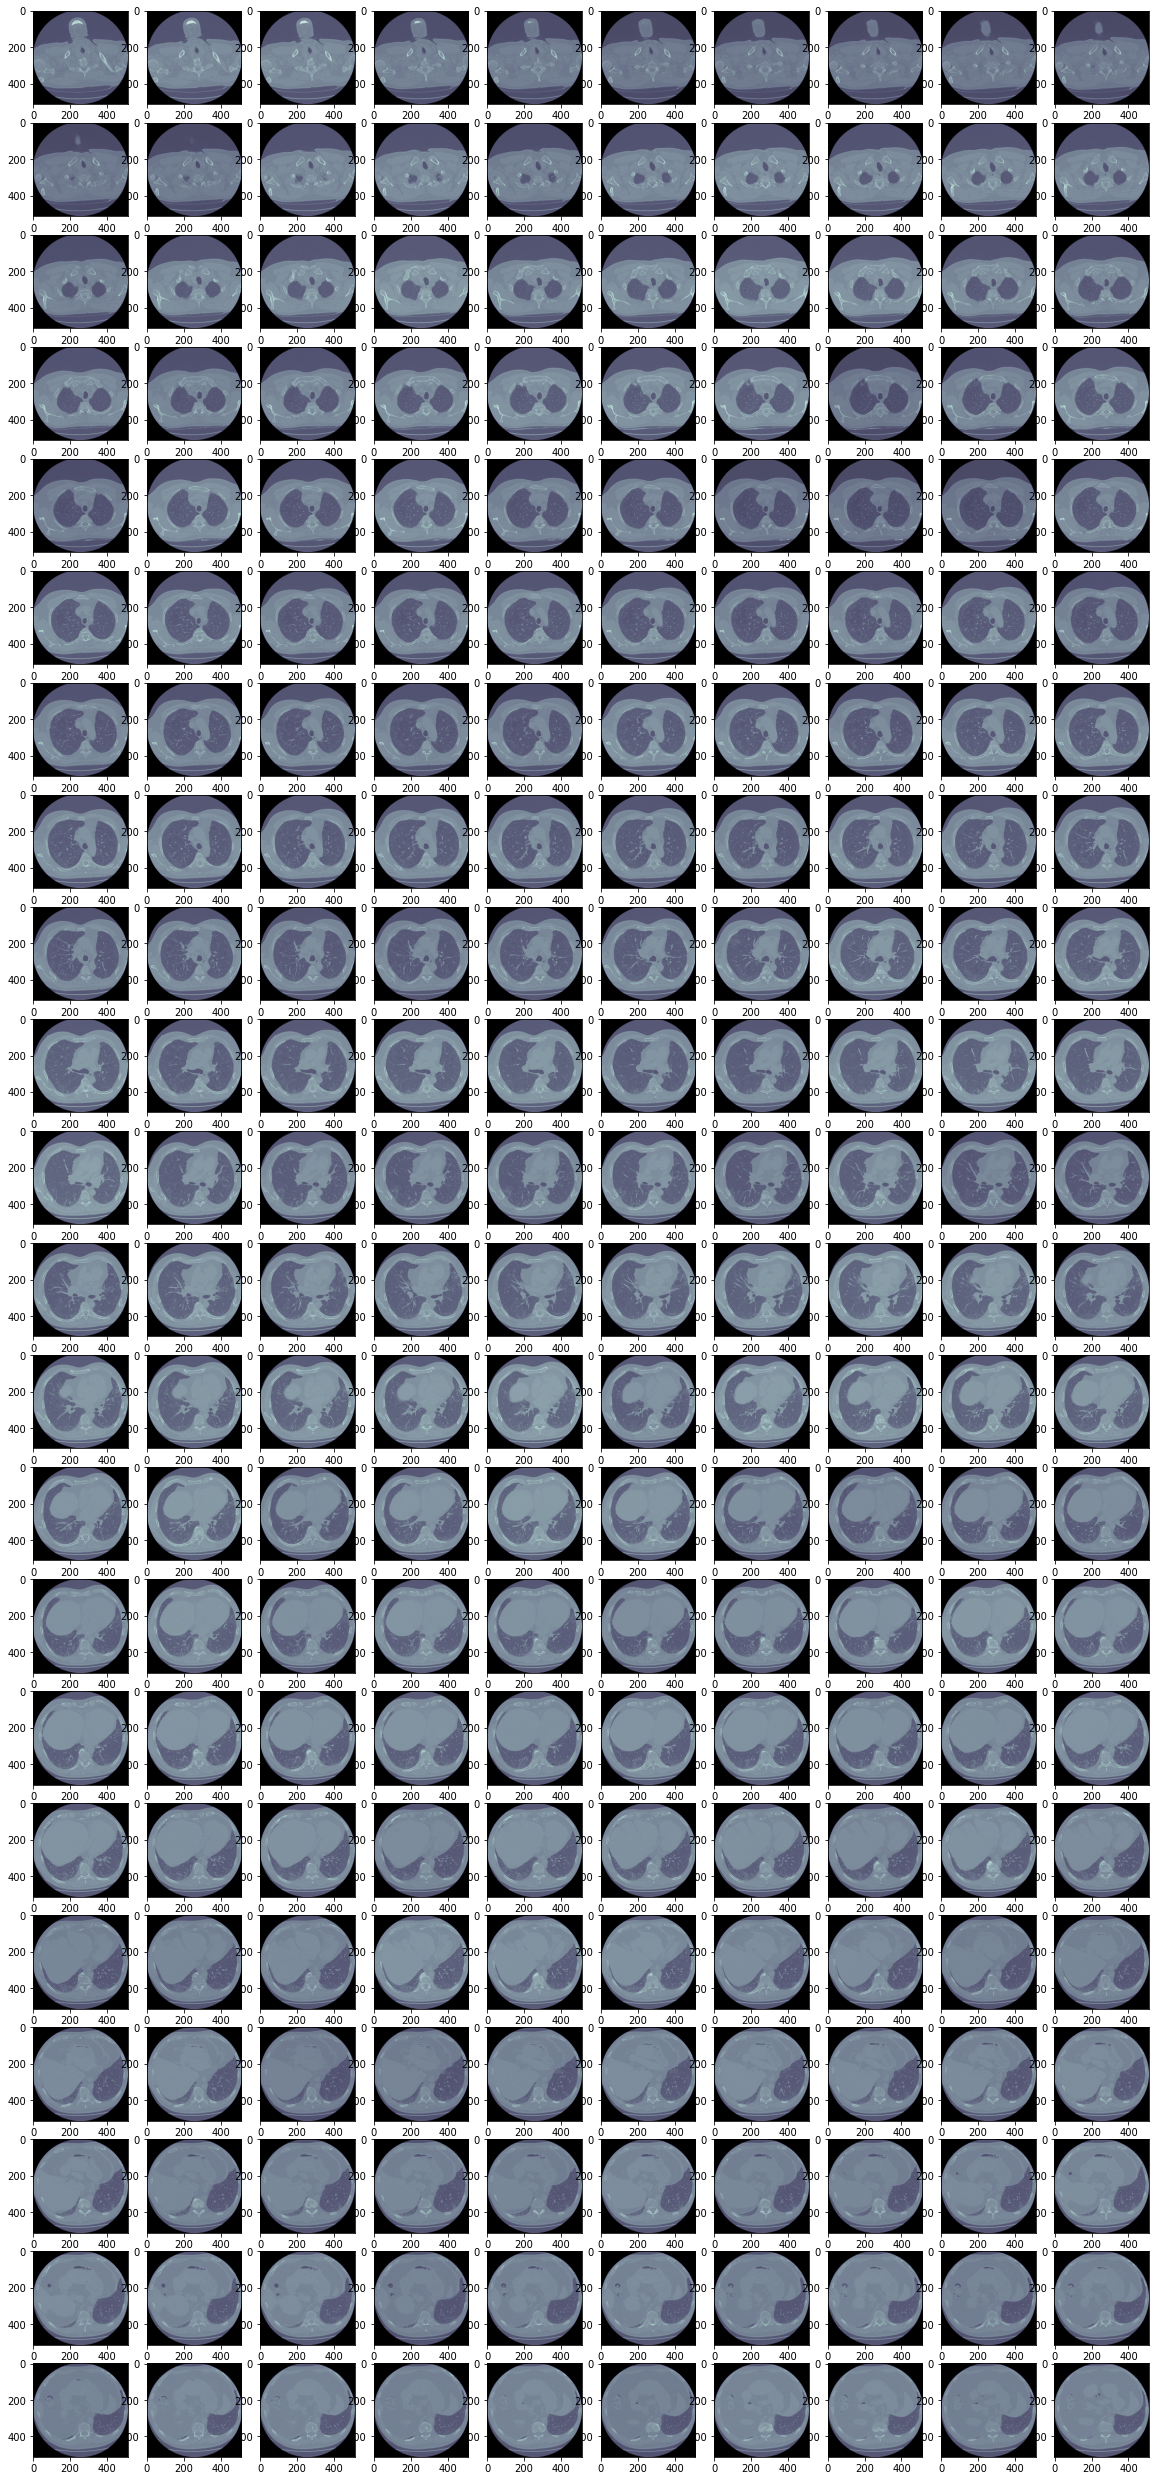

In [ ]:
fig = plt.figure(figsize=(20,45))
columns = 10
rows = 22
image_dir = 'drive1/Colab Notebooks/train2/ID00167637202237397919352'
for i in range(1,columns*rows +1):
  filename = image_dir + "/" + str(i) + ".dcm"
  ds = pydicom.dcmread(filename)
  fig.add_subplot(rows, columns, i)
  plt.imshow(ds.pixel_array, cmap = plt.cm.bone, aspect='auto')


Above list shows the CT-Scan files (.dcm) slice by slice (increasing order) of the chest from the patient ID : ID00167637202237397919352


## Full CT scan images

In [41]:
# ## https://www.kaggle.com/pranavkasela/interactive-and-animated-ct-scan
def sort_path_slide_dicom(patient_id):
  dicom_path = 'drive1/Colab Notebooks/train2/'
  files = np.array([f.replace(".dcm","") for f in os.listdir(f"{dicom_path}/{patient_id}/")])
  files = -np.sort(-files.astype("int"))
  dicom = [f"{dicom_path}/{patient_id}/{f}.dcm" for f in files]
  return dicom

#### Visualizations of top, front and side view.

In [42]:
## https://www.kaggle.com/pranavkasela/interactive-and-animated-ct-scan
## https://stackoverflow.com/a/32364177

def sort_slide_dicom_view(patient_id):
 
# Reading DCM files
  images = []
  for dcm in dicoms:
    tmp = dcmread(dcm)
    slope = tmp.RescaleSlope
    intercept = tmp.RescaleIntercept
    final = tmp.pixel_array*slope + intercept
    images.append(final)
    
  images = np.array(images) 

# Ploting
#top view
  fig = plt.figure()

  ims = []
  for image in range(0,images.shape[0],10):
    im = plt.imshow(images[image,:,:], animated=True, cmap=plt.cm.bone)
    plt.title('Top View of Patient ID: '+ patient_id)
    plt.axis("off")
    ims.append([im])
  anit = animation.ArtistAnimation(fig, ims, interval=100, blit=False, repeat_delay=1000)
  plt.close()

# Ploting
#front view
  fig = plt.figure()

  ims = []
  for image in range(0,images.shape[1],5):
    im = plt.imshow(images[:,image,:], animated=True, cmap=plt.cm.bone)
    plt.title('Front View of Patient ID: '+ patient_id)
    plt.axis("off")
    ims.append([im])
  anif = animation.ArtistAnimation(fig, ims, interval=100, blit=False, repeat_delay=1000)
  plt.close()

# Ploting
# Sidewise
  fig = plt.figure()

  ims = []
  for image in range(0,images.shape[2],5):
    im = plt.imshow(images[:,:,image], animated=True, cmap=plt.cm.bone)
    plt.title('Side View of Patient ID: '+ patient_id)
    plt.axis("off")
    ims.append([im])
  anis = animation.ArtistAnimation(fig, ims, interval=100, blit=False,repeat_delay=1000)

  plt.close()

  return anit, anif, anis;


##### Slider view of CT Scan

In [ ]:
patient_id = 'ID00167637202237397919352'
dicoms = sort_path_slide_dicom(patient_id)
sort_slide_dicom_view(patient_id)
anit, anif, anis = sort_slide_dicom_view(patient_id)
HTML(anit.to_jshtml()+anif.to_jshtml()+anis.to_jshtml()) 

### Metadata of CT-scan image file (1.dcm)

In [34]:
image_dir = 'drive1/Colab Notebooks/train2/'

In [33]:
# # Metadata of first image of CT scan having .dcm as extension of particular patient.
# https://stackoverflow.com/a/35466361
image_dir = 'drive1/Colab Notebooks/train2/'
folder_id = "ID00167637202237397919352"
filename = '1.dcm'
dcm_1 = dcmread(image_dir + folder_id + '/' + filename )

In [ ]:
print (dcm_1)  

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.15316764514779871135977247271653363554
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.15316764514779871135977247271653363554
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 